## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

# Data 
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum

# Tasks
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.utilities.ts_gapfilling import ModelGapFiller, SimpleGapFiller

import logging

In [26]:
# Outlier detection scratchwork
# Determine threshold, mark all points where |p2 - p1| > threshold as outlier
def calc_threshold(df: pd.DataFrame, metric: str):
    df['diff'] = df[metric].diff(periods=10)
    return df, abs(df['diff'].mean())

## Timeseries Bi-Directional Gap Filling
Base data from Peterson Flow Through:

8760


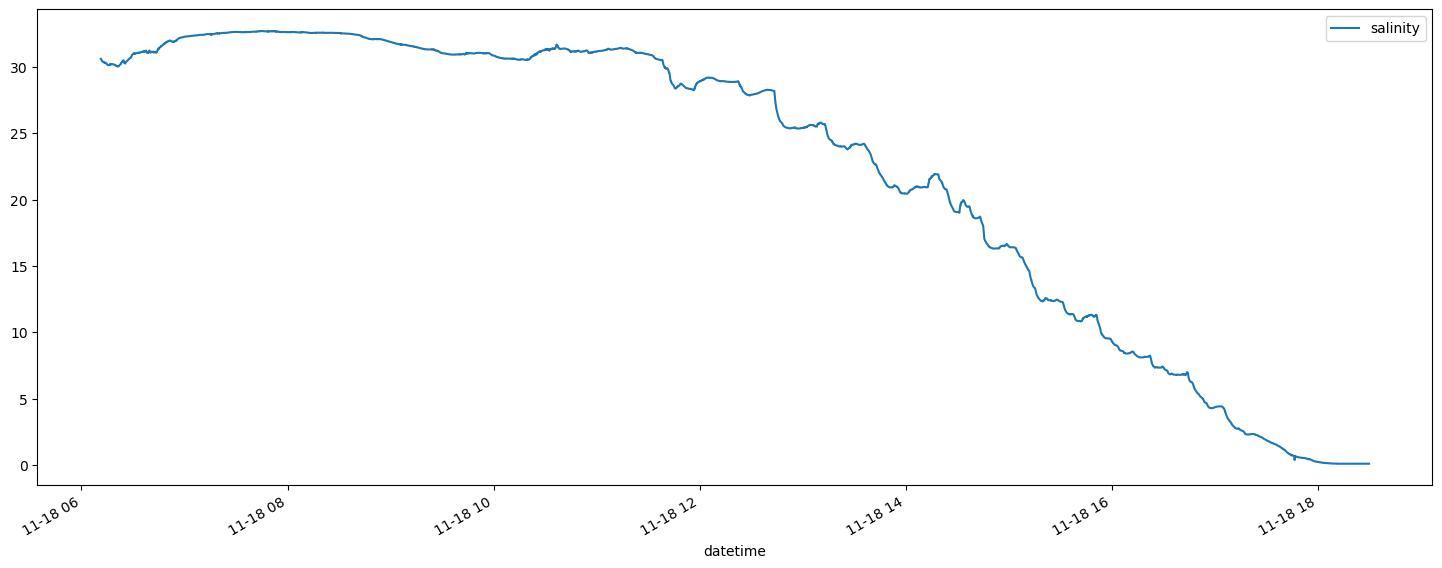

In [2]:
metric = 'salinity'

df = pd.read_parquet('../Peterson Flow Through/Merges/PETERSON_FINAL.parquet')#.sample(n=100000)
df.datetime = pd.to_datetime(df.datetime)
df = df[df.file == '14322dat.txt']
print(len(df))

# z-score filtering for local outliers
'''roll = df[metric].rolling(window=50, min_periods=1, center=True)
avg = roll.mean()
std = roll.std(ddof=0)
z = df[metric].sub(avg).div(std)
m = z.between(-1, 1)
df[metric] = df[metric].where(m, avg)'''

# We drop any value whose difference is > than N% the difference between the min/max values of our data
# 1-5% seems to be a solid threshold
thold = 0.01

max = df[metric].max()
min = df[metric].min()
prev = diff = 0
for i, row in df.iterrows():
    if i == 0: 
        prev = row[metric]
        continue

    diff = abs(prev - row[metric])
    prev = row[metric]

    if diff > ((max - min) * thold):
        df.drop(index=i, inplace=True)
        #print(f'dropped: {i} -- {row.salinity} -- {diff}')

df.plot('datetime', metric)
plt.show()

In [3]:
def generateGaps(withoutGaps, gapDict, gapValue):
    withGaps = np.copy(withoutGaps)

    keys = list(gapDict.keys())
    for key in keys:
        gapSize = gapDict.get(key)
        if gapSize == -1:
            withGaps[key:] = gapValue
        else:
            withGaps[key:(key + gapSize)] = gapValue

    return withGaps

gapDict = {2000: 1200, 6000: 700}
withGaps = generateGaps(df[metric].to_list(), gapDict=gapDict, gapValue=-100)

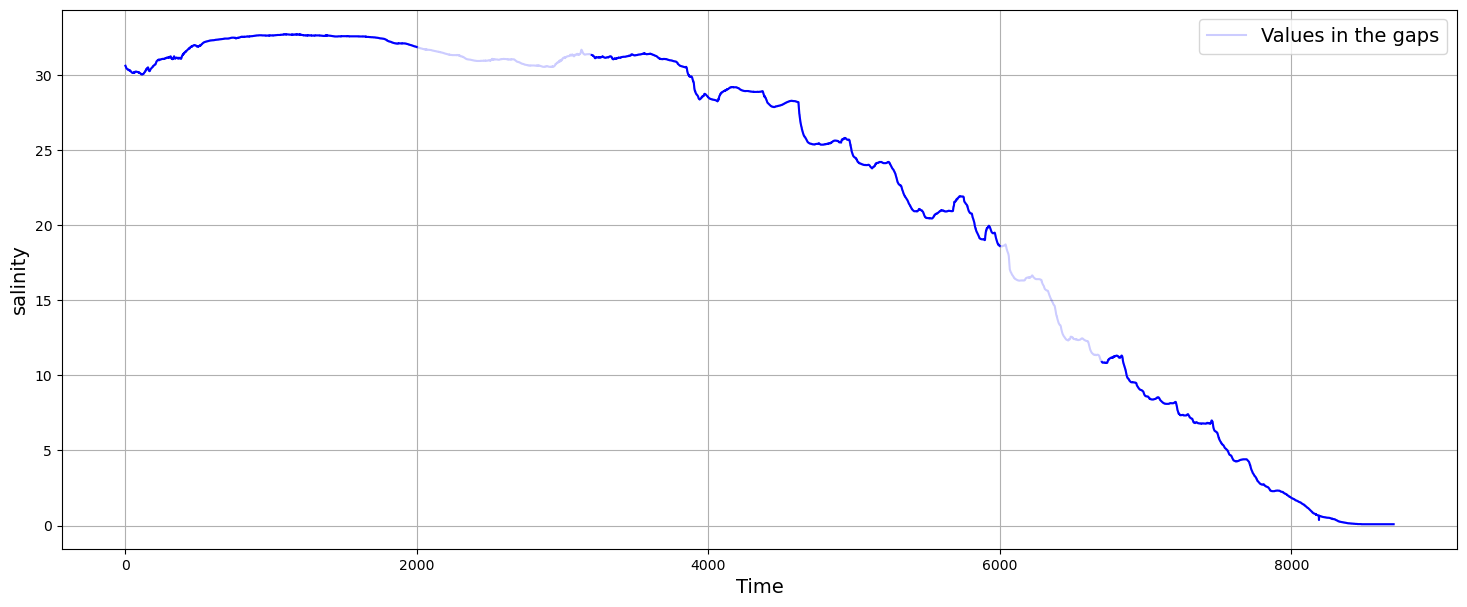

In [4]:
timeseries = np.array(df[metric])
masked_array = np.ma.masked_where(withGaps == -100.0, withGaps)

# Plot time series with gaps
plt.plot(timeseries, c='blue', alpha=0.2, label='Values in the gaps')
plt.plot(masked_array, c='blue', alpha=1.0)
plt.ylabel(f'{metric}', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

Gap filling:

In [5]:
def getSimpleRidgePipeline():
    nodeLagged = PrimaryNode('lagged')
    nodeLagged.custom_params = {'window_size': 750}

    nodeFinal = SecondaryNode('ridge', nodes_from=[nodeLagged])
    pipeline = Pipeline(nodeFinal)
    return pipeline

pipeline = getSimpleRidgePipeline()
modelGapFiller = ModelGapFiller(gap_value=-100, pipeline=pipeline)

withoutGapForward = modelGapFiller.forward_filling(withGaps)
withoutGapBidirect = modelGapFiller.forward_inverse_filling(withGaps)

2024-07-12 16:43:54,168 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2024-07-12 16:43:54,228 - ModelGapFiller - First element in the array were replaced by first known value
2024-07-12 16:43:54,241 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 57
2024-07-12 16:43:54,285 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 82
2024-07-12 16:43:54,305 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 100
2024-07-12 16:43:54,351 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 1651
2024-07-12 16:43:54,536 - LaggedTransformationImplementation - Window size of lagged

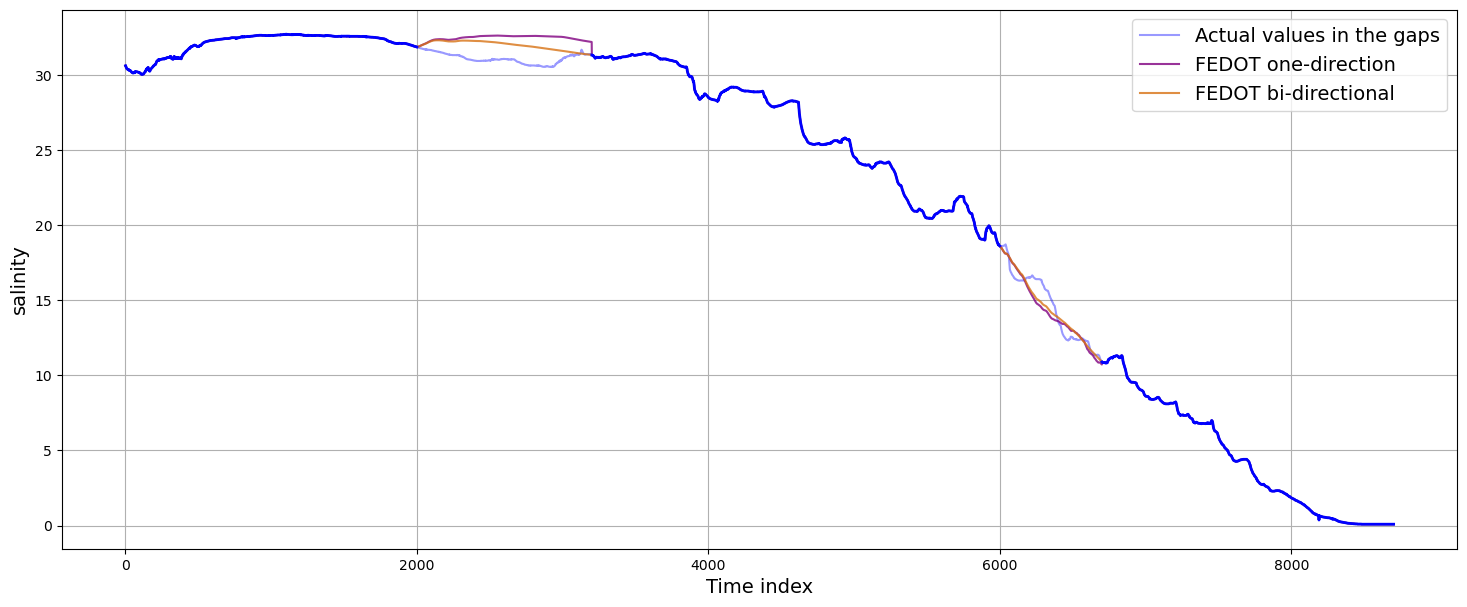

In [6]:
plt.plot(timeseries, c='blue', alpha=0.4, label='Actual values in the gaps')
plt.plot(withoutGapForward, c='purple', alpha=0.8, label='FEDOT one-direction')
plt.plot(withoutGapBidirect, c='#D77214', alpha=0.8, label='FEDOT bi-directional')
plt.plot(masked_array, c='blue', alpha=1.0, linewidth=2)
plt.ylabel(f'{metric}', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()